In [1]:
import scanpy as sc


adata = sc.read_h5ad(
    '../data/tcells.tissue.scps.integrated.clustered.h5ad'
)
adata

AnnData object with n_obs × n_vars = 62432 × 20912
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types', 'leiden_scvi_0.4', 't_cell_types'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [10]:
from sctools import io


is_treg = adata.obs.t_cell_types == 'Treg'
is_normal = adata.obs.status == 'normal'
is_sc = adata.obs.status == 'sarcoidosis'
is_ps = adata.obs.status == 'psoriasis'


for k in ['psoriasis', 'sarcoidosis']:
    subset = adata[is_treg & (is_normal | (adata.obs.status == k)), :]
    io.write_sc_data(
        subset,
        f'../diffexp/tregs.tissue.{k}',
        obs_columns = ['sample_id', 'status']
    )

Global seed set to 0


differential expression is done in R with MAST

In [52]:
import pandas as pd

sc_deg_results = pd.read_csv(
    '../diffexp/tregs.tissue.sc.de.signif.tsv',
    sep = '\t'
)
sc_deg_results

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,significant,gene
0,0.000000e+00,-2.566487,0.066,0.698,0.000000e+00,True,ALDOA
1,0.000000e+00,1.476685,0.825,0.426,0.000000e+00,True,ARL4C
2,0.000000e+00,2.004872,0.726,0.330,0.000000e+00,True,ATP1B3
3,0.000000e+00,-1.872508,0.001,0.514,0.000000e+00,True,ATP6V0C
4,0.000000e+00,-1.238117,0.768,0.905,0.000000e+00,True,CD3E
...,...,...,...,...,...,...,...
631,1.059204e-29,0.513330,0.608,0.509,2.215008e-25,True,TRBC1
632,5.091065e-29,-0.656529,0.062,0.153,1.064643e-24,True,HILPDA
633,1.307012e-25,0.546752,0.597,0.551,2.733224e-21,True,DDIT4
634,1.232993e-22,0.556169,0.327,0.232,2.578435e-18,True,ID3


In [53]:
ps_deg_results = pd.read_csv(
    '../diffexp/tregs.tissue.ps.de.signif.tsv',
    sep = '\t'
)
ps_deg_results

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,significant,gene
0,0.000000e+00,1.902245,0.623,0.268,0.000000e+00,True,DUSP1
1,0.000000e+00,-3.026424,0.448,0.932,0.000000e+00,True,MT-ATP6
2,0.000000e+00,-2.047994,0.627,0.962,0.000000e+00,True,MT-CO1
3,0.000000e+00,-1.477700,0.737,0.957,0.000000e+00,True,MT-CO2
4,0.000000e+00,-1.858589,0.608,0.938,0.000000e+00,True,MT-CO3
...,...,...,...,...,...,...,...
254,9.053692e-37,0.630884,0.211,0.116,1.893308e-32,True,NR4A2
255,9.530925e-30,-0.635616,0.925,0.952,1.993107e-25,True,RPL21
256,2.531431e-29,0.574932,0.167,0.110,5.293728e-25,True,GEM
257,1.709605e-23,1.267784,0.160,0.197,3.575125e-19,True,HSPA1B


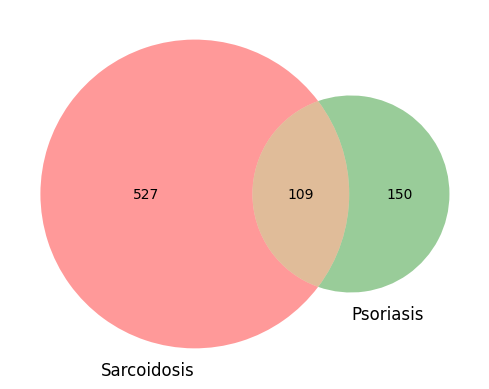

In [54]:
%matplotlib inline
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

sc_degs = set(sc_deg_results.gene)
ps_degs = set(ps_deg_results.gene)

fig, ax = plt.subplots()
venn = venn2(
    [sc_degs, ps_degs], 
    set_labels = ['Sarcoidosis', 'Psoriasis'],
    ax = ax
)

In [55]:
all(['SAT1' in gene_set for gene_set in [ps_degs, sc_degs]])

True

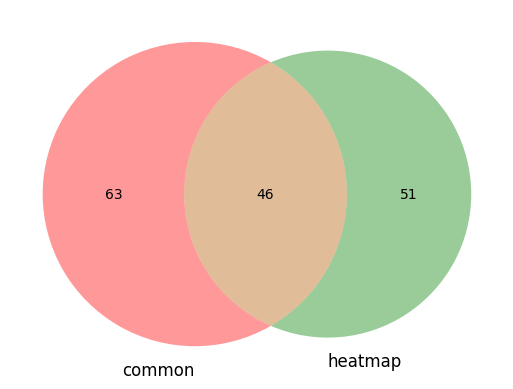

In [56]:
heatmap_genes = pd.read_csv(
    '../resource/DEGs_grouped_updated.txt',
    sep = '\t'
)
common_degs = sc_degs & ps_degs
heatmap_genes_set = set(
    heatmap_genes.loc[heatmap_genes.Tissue == 'skin', 'Gene']
)
fig, ax = plt.subplots()
venn = venn2(
    [common_degs, heatmap_genes_set], 
    set_labels = ['common', 'heatmap'],
    ax = ax
)

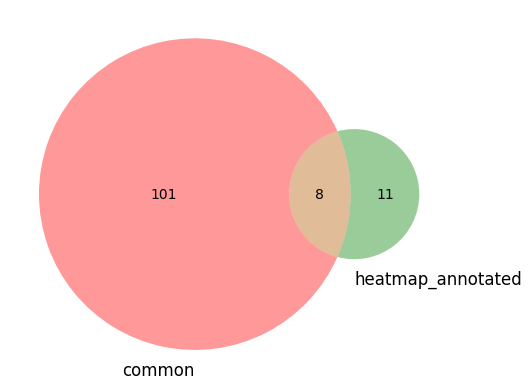

In [58]:
assorted_genes = set(
    [
        'TNFRSF4', 'CD69', 'TNFRSF9', 'ICOS', 
        'YWHAH', 'ODC1', 'GLS', 'SAT1', 'SLC2A3', 
        'NFKB2', 'IRF1', 'NFKBIA', 'REL', 'SOCS1', 
        'SOCS3', 'JUN', 'JUNB', 'FOS', 'JUND'
    ]
)
fig, ax = plt.subplots()
venn = venn2(
    [common_degs, assorted_genes], 
    set_labels = ['common', 'heatmap_annotated'],
    ax = ax
)